## Linear Reaction-Convection-Diffusion Equation

We are going to simulate the fire spreading using this equation

\begin{equation}
    \frac{\partial u}{\partial t} = \mu \nabla^2u + \nabla \cdot (u\textbf{v})+au,
\end{equation}

where $u$ represents the temperature in domain $\Omega \in \mathbb{R}^n$, $\mu>0$ is the diffusion constant, $\textbf{v}(\textbf{x})=(v_1(\textbf{x}), ..., v_n(\textbf{x}))$ a fluid field and $a(\textbf{x})$ is a reaction rate.

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [4]:
def cheb(N):
    if N == 0:
        D = 0
        x = 1
        return D, x
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.hstack((2, np.ones(N - 1), 2)) * ((-1.)**np.arange(N + 1))
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T
    D = np.outer(c, 1./c) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D.T, axis=0))
    return D,x

### Diffusion term

\begin{equation}
    \begin{split}
        \frac{\partial u}{\partial t} &= \mu \nabla^2u \\
        u(\textbf{x},t) & = 0 \quad \forall \textbf{x} \in \partial \Omega \\
        u(\textbf{x},0) & = f(\textbf{x})
    \end{split}
\end{equation}

In [161]:
N = 20

# x variable in [-1,1], Chebyshev:
Nx = N; Dx, x = cheb(Nx)
D2x = np.dot(Dx, Dx);

# y variable in [-1,1], Chebyshev:
Ny = N; Dy, y = cheb(Ny) 
D2y = np.dot(Dy, Dy)

# Grid and initial data:
X, Y = np.meshgrid(x,y)

In [162]:
v = np.exp(-4*(X**2 + Y**2))
mu = 1
dt = 1e-4
tmax = 4000

u = [v]
t = [0]

# Euler
for n in range(tmax):
    v = v + dt*mu*(np.dot(v, D2x) + np.dot(D2y, v))

    # Border condition
    v[0,:] = np.zeros(N+1)
    v[-1,:] = np.zeros(N+1)
    v[:,0] = np.zeros(N+1)
    v[:,-1] = np.zeros(N+1)
    
    if (n % 2 == 0): # keep some plots
        u.append(v)
        t.append(n*dt)

### Diffusion + Reaction term

\begin{equation}
    \begin{split}
        \frac{\partial u}{\partial t} &= \mu \nabla^2u + au\\
        u(\textbf{x},t) & = 0 \quad \forall \textbf{x} \in \partial \Omega \\
        u(\textbf{x},0) & = f(\textbf{x})
    \end{split}
\end{equation}

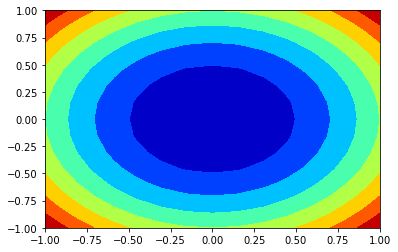

In [178]:
v = np.exp(-4*(X**2 + Y**2))
mu = 1
#a = np.random.rand(N+1, N+1)
a = X**2 + Y**2 #np.cos(np.pi/8*X*Y)
plt.contourf(X, Y, a, cmap=cm.jet)
dt = 1e-4
tmax = 4000

u = [v]
t = [0]

# Euler
for n in range(tmax):
    v = v + dt*mu*(np.dot(v, D2x) + np.dot(D2y, v) + np.dot(a, v))

    # Border condition
    v[0,:] = np.zeros(N+1)
    v[-1,:] = np.zeros(N+1)
    v[:,0] = np.zeros(N+1)
    v[:,-1] = np.zeros(N+1)
    
    if (n % 2 == 0): # keep some plots
        u.append(v)
        t.append(n*dt)

In [172]:
fine = np.linspace(-1, 1, 2*N)
Xf, Yf = np.meshgrid(fine, fine)

def plot(d, i):
    f = interp2d(x, y, u[i], kind='cubic')
    v = f(fine, fine)    
    vmn, vmx = np.min(u[0]), np.max(u[0])
    fig = plt.figure(figsize=(10, 8))
    if d == 2:        
        ax = fig.gca(projection='3d')                        
        surf = ax.plot_surface(Xf, Yf, v, rstride=1, cstride=1, cmap=cm.jet, vmin=vmn, vmax=vmx)  
        fig.colorbar(surf)
        ax.view_init(elev=30., azim=230.)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u(x,y)")
        ax.set_zlim([vmn, vmx])
    else:        
        cont = plt.contourf(Xf, Yf, v, cmap=cm.jet, vmin=vmn, vmax=vmx)
        fig.colorbar(cont)
        #plt.imshow(v, cmap=cm.jet, origin="lower", extent=[-1,1,-1,1], vmin=np.min(u[0]), vmax=np.max(u[0]))        
        #plt.colorbar()
        
    plt.title("$t$: " + "{:10.2f}".format(t[i]))
    plt.show()

slider = widgets.IntSlider(
    value=0, 
    min=0, 
    max=len(t)-1, 
    step=1, 
    description='Time step:',
    continuous_update=False,
    readout=True,
    readout_format='d')

drop = widgets.Dropdown(
    options={'Contour': 1, 'Surface': 2},
    value=1,
    description='Plot:',
)

widgets.interact(plot, d=drop, i=slider)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 1, 'Surface': 2}, value=1), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

### Vector Field

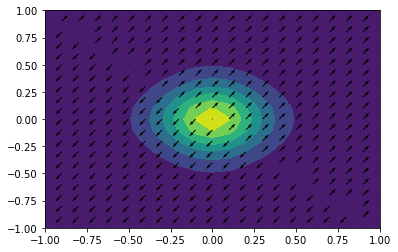

In [85]:
# Vector Field
X, Y = np.mgrid[-1:1:21j, -1:1:21j]
U = X+Y
V = X+Y
#Z = np.exp(-4*(X**2 + Y**2))
#U = -8*X*np.exp(-4*(X**2 + Y**2))
#V = -8*Y*np.exp(-4*(X**2 + Y**2))
speed = np.sqrt(U**2 + V**2)
speed[speed == 0] = 1e-16
UN = U/speed
VN = V/speed
cp = plt.contourf(X, Y, u[0])
quiv = plt.quiver(X, Y, UN, VN)
plt.show()